# Data Integration

In [1]:
import os, re, sys
import fcsparser
import pandas as pd

sys.path.insert(0, "../..")
from scripts.aux_functions import *


In [2]:
# Import raw data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/CyTOF/CellChat Follow-up"
os.makedirs(f"{base_dir}/output", exist_ok=True)
input_dir = f"{base_dir}/preprocessed_data"
output_dir = f"{base_dir}/output"

filelist = [f for f in os.listdir(input_dir) if f.endswith(".txt")]
filelist


['B2_CellChat_AK_092_TGFB2_2.txt',
 'B2_CellChat_AKP_085_WNT5A_1.txt',
 'B2_CellChat_WT_003_Ctrl_3.txt',
 'B2_CellChat_KP_039_Ctrl_3.txt',
 'B2_CellChat_AKP_083_EGF_2.txt',
 'B2_CellChat_KP_058_TGFB2_1.txt',
 'B5_CellChat_A_055_EGF_1.txt',
 'B2_CellChat_AK_105_EREG_3.txt',
 'B2_CellChat_KP_072_OPN_3.txt',
 'B2_CellChat_AKP_098_IGF1_2.txt',
 'B5_CellChat_WT_013_WNT5A_1.txt',
 'B2_CellChat_WT_008_WNT3A_2.txt',
 'B5_CellChat_A_051_Ctrl_3.txt',
 'B5_CellChat_A_065_SEMA3A_2.txt',
 'B2_CellChat_AKP_107_OPN_2.txt',
 'B2_CellChat_A_044_WNT3A_2.txt',
 'B2_CellChat_AK_094_TGFB1_1.txt',
 'B5_CellChat_WT_041_EREG_2.txt',
 'B2_CellChat_KP_045_WNT3A_3.txt',
 'B2_CellChat_K_032_EREG_2.txt',
 'B2_CellChat_K_016_SEMA3A_1.txt',
 'B2_CellChat_K_008_WNT3A_2.txt',
 'B2_CellChat_K_019_TGFB2_1.txt',
 'B2_CellChat_AKP_092_TGFB2_2.txt',
 'B2_CellChat_K_035_OPN_2.txt',
 'B5_CellChat_A_081_IGF1_3.txt',
 'B2_CellChat_K_017_SEMA3A_2.txt',
 'B2_CellChat_AK_101_NRG1_2.txt',
 'B2_CellChat_K_024_TGFB1_3.txt',
 'B2_Cel

In [3]:
# ---
# Integration
# ---

# Naming convention:
# batch_experiment_barcode_genotype_condition_replicate
# e.g. "B1_CellChat_WT_001_Ctrl_1.txt"

integrated = pd.DataFrame()
for f in filelist:
    df_new = pd.read_csv(f"{input_dir}/{f}", sep="\t")
    df_new = df_new.rename(
        columns=lambda x: re.sub("_v[0-9]+$", "", x)
    )  # Revome the version number etc.

    batch = f.split("_")[0]
    genotype = f.split("_")[2]
    barcode = f.split("_")[3]
    media = f.split("_")[4]
    replicate = f.split("_")[-1].split(".")[0]

    df_new["batch"] = batch
    df_new["barcode"] = barcode
    df_new["genotype"] = genotype
    df_new["media"] = media
    df_new["replicate"] = replicate
    df_new["culture"] = genotype + "_" + media
    df_new["condition"] = batch + "_" + genotype + "_" + media + "_" + replicate

    # break down genotype
    df_new["A"] = 1 if "A" in genotype else 0
    df_new["K"] = 1 if "K" in genotype else 0
    df_new["P"] = 1 if "P" in genotype else 0

    integrated = pd.concat([integrated, df_new])
integrated.head()
integrated.shape

integrated.columns.values
integrated.to_csv(f"{output_dir}/integrated_dataframe_all-cells.csv", index=False)


# EMD Calculation

In [4]:
import os
import pandas as pd
import scprep
from scipy.stats import zscore

sys.path.insert(0, "../..")
from scripts.aux_functions import *
from scripts.__init__ import non_marker


In [5]:
# Import data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/CyTOF/CellChat Follow-up"
input_dir = f"{base_dir}/output"
os.makedirs(f"{base_dir}/output/emd", exist_ok=True)
output_dir = f"{base_dir}/output/emd"


In [6]:
# Generate full_panel and metadata_columns on the fly
df = pd.read_csv(f"{input_dir}/integrated_dataframe_all-cells.csv")
df_columns = df.columns.values.tolist()
column_filtered = list(
    filter(lambda x: x not in non_marker, df_columns)
)  # Exclude non-markers

full_panel = [i for i in column_filtered if i[0].isdigit()]
metadata_columns = list(filter(lambda x: x not in full_panel, column_filtered))


In [7]:
# EMD calculation - WT & A, Batch 2
subsets = ["WT", "A"]
batch = "B2"

for subset in subsets:

    subset_df = df.loc[(df["batch"] == batch) & (df["genotype"] == subset)]
    subset_df = arcsinh_transf(subset_df, full_panel, 5)  # Arcsinh transformation
    emd_ref = subset_df.loc[
        subset_df["culture"] == f"{subset}_Ctrl"
    ]  # for each genotype

    # EMD calculation
    emd_df = pd.DataFrame()
    emd_df_master = pd.DataFrame()
    emd_infodict = {}

    # Get all experimental conditions for which EMD is going to be calculated
    conditions = subset_df["condition"].unique().tolist()
    len(conditions)

    # Compute EMD and compile the result in a master dataframe
    for condition in conditions:
        compare_from = subset_df.loc[subset_df["condition"] == condition]

        df_new = calculate_emd(
            full_panel,  # all non-marker and non-metadata columns
            compare_from,
            emd_ref,
            metadata_columns,
            emd_df,
            emd_infodict,
        )
        emd_df_master = pd.concat([emd_df_master, df_new])

    # Long to wide transformation
    emd_df_master_wide = emd_df_master.pivot_table(
        index=metadata_columns,
        columns="marker",
        values="EMD_arc",
    ).reset_index()

    emd_df_master_wide.head()
    emd_df_master_wide.to_csv(
        f"{output_dir}/emd_df_master_{subset}_{batch}_no-norm.csv",
        index=False,
    )


In [8]:
# EMD calculation - WT & A, Batch 2
subsets = ["WT", "A"]
batch = "B5"

for subset in subsets:

    subset_df = df.loc[(df["batch"] == batch) & (df["genotype"] == subset)]
    subset_df = arcsinh_transf(subset_df, full_panel, 5)  # Arcsinh transformation
    emd_ref = subset_df.loc[
        subset_df["culture"] == f"{subset}_Ctrl"
    ]  # for each genotype

    # EMD calculation
    emd_df = pd.DataFrame()
    emd_df_master = pd.DataFrame()
    emd_infodict = {}

    # Get all experimental conditions for which EMD is going to be calculated
    conditions = subset_df["condition"].unique().tolist()
    len(conditions)

    # Compute EMD and compile the result in a master dataframe
    for condition in conditions:
        compare_from = subset_df.loc[subset_df["condition"] == condition]

        df_new = calculate_emd(
            full_panel,  # all non-marker and non-metadata columns
            compare_from,
            emd_ref,
            metadata_columns,
            emd_df,
            emd_infodict,
        )
        emd_df_master = pd.concat([emd_df_master, df_new])

    # Long to wide transformation
    emd_df_master_wide = emd_df_master.pivot_table(
        index=metadata_columns,
        columns="marker",
        values="EMD_arc",
    ).reset_index()

    emd_df_master_wide.head()
    emd_df_master_wide.to_csv(
        f"{output_dir}/emd_df_master_{subset}_{batch}_no-norm.csv",
        index=False,
    )


In [9]:
# K, AK, KP, and AKP

subsets = ["K", "AK", "KP", "AKP"]

for subset in subsets:

    if subset != "all-cells":
        subset_df = df.loc[df["genotype"] == subset]
        subset_df = arcsinh_transf(subset_df, full_panel, 5)  # Arcsinh transformation
        emd_ref = subset_df.loc[
            subset_df["culture"] == f"{subset}_Ctrl"
        ]  # for each genotype
    else:
        subset_df = arcsinh_transf(df, full_panel, 5)
        emd_ref = subset_df.loc[subset_df["culture"] == "WT_Ctrl"]

    # EMD calculation
    emd_df = pd.DataFrame()
    emd_df_master = pd.DataFrame()
    emd_infodict = {}

    # Get all experimental conditions for which EMD is going to be calculated
    conditions = subset_df["condition"].unique().tolist()
    len(conditions)

    # Compute EMD and compile the result in a master dataframe
    for condition in conditions:
        compare_from = subset_df.loc[subset_df["condition"] == condition]

        df_new = calculate_emd(
            full_panel,  # all non-marker and non-metadata columns
            compare_from,
            emd_ref,
            metadata_columns,
            emd_df,
            emd_infodict,
        )
        emd_df_master = pd.concat([emd_df_master, df_new])

    # Long to wide transformation
    emd_df_master_wide = emd_df_master.pivot_table(
        index=metadata_columns,
        columns="marker",
        values="EMD_arc",
    ).reset_index()

    emd_df_master_wide.head()
    emd_df_master_wide.to_csv(
        f"{output_dir}/emd_df_master_{subset}_no-norm.csv",
        index=False,
    )


In [10]:
# Concatenate the EMD scores per genotype
subsets = ["WT", "A", "K", "AK", "KP", "AKP"]

# No normalisation
emd_concat_nonorm = pd.DataFrame()
nonorm_dataset = [
    f
    for f in os.listdir(output_dir)
    if f.startswith("emd_df_master")
    # and f.endswith("no-norm.csv")
    and "no-norm" in f and f.split("_")[3] in subsets
]
nonorm_dataset
for f in nonorm_dataset:
    df = pd.read_csv(f"{output_dir}/{f}")
    emd_concat_nonorm = pd.concat([emd_concat_nonorm, df])
emd_concat_nonorm.head()
emd_concat_nonorm.shape
emd_concat_nonorm.to_csv(f"{output_dir}/emd_df_master_concat_no-norm.csv", index=False)


# EMD-PCA

In [11]:
import os, sys
import pandas as pd
import numpy as np
import phate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../..') # Add the script folder to the path
from scripts.aux_functions import *
from scripts import colours

from IPython.core.interactiveshell import InteractiveShell
%load_ext nb_black

<IPython.core.display.Javascript object>

In [12]:
# Import data
base_dir = "/Users/xiaoqin/Dropbox/TAPE LAB/Manuscripts/Qin & Cardoso Rodriguez et al/SupplementaryMaterials/Qin-CardosoRodriguez-et-al_analysis/CyTOF/CellChat Follow-up"
input_dir = f"{base_dir}/output/emd"
output_dir = f"{base_dir}/output/"

# Set experimental metadata
subset = "concat"
norm = "no-norm"

emd_df_master_wide = pd.read_csv(f"{input_dir}/emd_df_master_{subset}_{norm}.csv")
emd_df_master_wide.head()
emd_df_master_wide.columns

# Define markers used for PCA
dr_panel = [
    # cell-type
    "111Cd_CD44",
    # "113In_CEACAM1_CD66a",
    # "115In_Pan-CK",
    # "116Cd_GFP",
    "143Nd_C-MYC_1",
    "162Dy_LRIG1_1",
    "169Tm_EPHB2",
    "171Yb_SOX9_5",
    "174Yb_Clusterin_1",
    "175Lu_Survivin_2",
    "176Yb_FABP2",
]

dr_matrix = master_df_subset(emd_df_master_wide, dr_panel)


<IPython.core.display.Javascript object>

In [13]:
# ---
# PCA
# ---

pca = PCA(n_components=2)
pca.fit(dr_matrix)

Y_pca = pca.transform(dr_matrix)
pc1 = round(pca.explained_variance_ratio_[0] * 100, 2)  # %variance explained
pc2 = round(pca.explained_variance_ratio_[1] * 100, 2)

# Join PCA coordinates with EMD dataframe
Y_pca_df = pd.DataFrame(Y_pca).reset_index()
emd_df_master_wide = emd_df_master_wide.reset_index(drop=True).reset_index()
Y_pca_df = pd.merge(emd_df_master_wide, Y_pca_df, on="index")
Y_pca_df.drop(columns=["index"], inplace=True)
emd_df_master_wide.drop(columns="index", inplace=True)
Y_pca_df.head()


,batch,barcode,genotype,media,replicate,culture,condition,A,K,P,...,174Yb_Clusterin_1,175Lu_Survivin_2,176Yb_FABP2,191Ir_DNA 1,193Ir_DNA 2,194Pt_Cisplatin,209Bi_DiMeHH3_K4,89Y_pHH3_S28,0,1
0,B2,37,KP,Ctrl,1,KP_Ctrl,B2_KP_Ctrl_1,0,1,1,...,0.160659,0.048911,-0.059880,0.020784,0.020311,0.029405,-0.058917,0.022633,-0.059103,-0.096956
1,B2,38,KP,Ctrl,2,KP_Ctrl,B2_KP_Ctrl_2,0,1,1,...,-0.053910,-0.033219,0.113322,-0.011114,-0.010597,-0.101579,0.072220,0.017631,-0.162410,0.049063
2,B2,39,KP,Ctrl,3,KP_Ctrl,B2_KP_Ctrl_3,0,1,1,...,-0.128658,-0.024540,-0.091181,-0.016513,0.017201,0.115308,-0.046429,-0.040368,-0.095140,0.231347
3,B2,43,KP,WNT3A,1,KP_WNT3A,B2_KP_WNT3A_1,0,1,1,...,1.573649,-0.240639,-0.302297,-0.098076,-0.095550,0.099822,-0.817154,-0.159309,1.410704,-0.646976
4,B2,44,KP,WNT3A,2,KP_WNT3A,B2_KP_WNT3A_2,0,1,1,...,2.050376,-0.189859,-0.448980,-0.064793,-0.062799,0.087057,-0.758621,-0.130683,1.662728,-1.064709


<IPython.core.display.Javascript object>

## Plots split by genotype

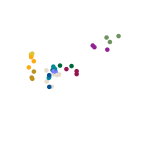

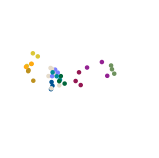

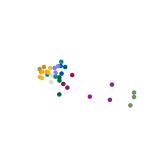

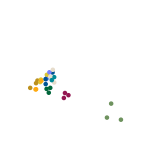

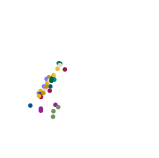

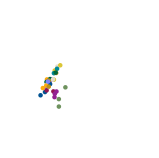

<IPython.core.display.Javascript object>

In [14]:
genotypes = ["WT", "A", "K", "KP", "AK", "AKP"]

for genotype in genotypes:

    Y_pca_df_subset = Y_pca_df[Y_pca_df["genotype"] == genotype]
    # Adjust the plotting order
    Y_pca_df_subset_ctrl = Y_pca_df_subset.loc[Y_pca_df_subset["media"] == "Ctrl"]
    Y_pca_df_subset_other = Y_pca_df_subset.loc[
        -Y_pca_df_subset["media"].isin(["Ctrl"])
    ]
    Y_pca_df_subset = pd.concat([Y_pca_df_subset_other, Y_pca_df_subset_ctrl])

    facets = ["media"]
    for facet in facets:
        fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
        ax.set_xlim(-1.2, 2.4),
        ax.set_ylim(-1.8, 1.8),
        [x.set_linewidth(0.5) for x in ax.spines.values()]

        fig = scprep.plot.scatter2d(
            Y_pca_df_subset.iloc[:, -2:],
            c=Y_pca_df_subset.loc[:, facet],
            cmap=colours,
            ticks=False,
            s=5,
            # xlabel=f"PC1_{pc1}%",
            # ylabel=f"PC2_{pc2}%",
            xlabel="",
            ylabel="",
            legend=False,
            # title=facet,
            legend_ncol=2,
            ax=ax,
        )
        fig.axis("off")
        # plt.savefig(
        #     f"{output_dir}/EMD-PCA_concat_{genotype}_{facet}.pdf",
        #     bbox_inches="tight",
        # )


## Metadata (Figure S5)

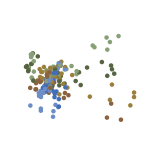

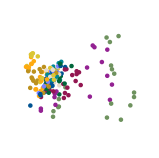

<IPython.core.display.Javascript object>

In [15]:
facets = ["genotype", "media"]

for facet in facets:

    # Adjust the plotting order
    Y_pca_df_ctrl = Y_pca_df.loc[Y_pca_df["media"] == "Ctrl"]
    Y_pca_df_other = Y_pca_df.loc[-Y_pca_df["media"].isin(["Ctrl"])]
    Y_pca_df = pd.concat([Y_pca_df_other, Y_pca_df_ctrl])

    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
    ax.set_xlim(-1.2, 2.4),
    ax.set_ylim(-1.8, 1.8),
    [x.set_linewidth(0.5) for x in ax.spines.values()]

    fig = scprep.plot.scatter2d(
        Y_pca_df.iloc[:, -2:],
        c=Y_pca_df.loc[:, facet],
        cmap=colours,
        ticks=False,
        s=5,
        # xlabel=f"PC1_{pc1}%",
        # ylabel=f"PC2_{pc2}%",
        xlabel="",
        ylabel="",
        legend=False,
        # title=facet,
        legend_ncol=2,
        ax=ax,
    )
    fig.axis("off")
    # plt.savefig(
    #     f"{output_dir}/EMD-PCA_concat_{facet}.pdf",
    #     bbox_inches="tight",
    #     )


## CLU & SURVIVIN

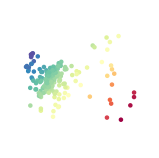

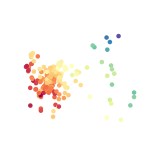

<IPython.core.display.Javascript object>

In [16]:
for marker in ["174Yb_Clusterin_1", "175Lu_Survivin_2"]:
    fig, ax = plt.subplots(1, 1, figsize=(1.8, 1.8))
    ax.set_xlim(-1.2, 2.4),
    ax.set_ylim(-1.8, 1.8),
    [x.set_linewidth(0.5) for x in ax.spines.values()]

    fig = scprep.plot.scatter2d(
        Y_pca_df.iloc[:, -2:],
        c=Y_pca_df.loc[:, marker],
        cmap=sns.color_palette("Spectral_r", as_cmap=True),
        ticks=False,
        s=5,
        # xlabel=f"PC1_{pc1}%",
        # ylabel=f"PC2_{pc2}%",
        xlabel="",
        ylabel="",
        legend=False,
        title="",
        # legend_ncol=2,
        ax=ax,
    )
    fig.axis("off")
    # plt.savefig(
    #     f"{output_dir}/EMD-PCA_concat_{marker}.pdf",
    #     bbox_inches="tight",
    #     )
